### For a setup of DW, load the VGP model and train t-VGP model to match the ELBO.

In [1]:
import os
import numpy as np
import wandb
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
from gpflow.likelihoods import Gaussian

from markovflow.sde.sde import PriorDoubleWellSDE
from docs.sde.t_vgp_trainer import tVGPTrainer
from docs.sde.sde_exp_utils import predict_ssm

2022-08-24 11:22:48.807658: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-24 11:22:48.807686: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-24 11:22:50.389316: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-24 11:22:50.390009: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-24 11:22:50.417355: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-08-24 11:22:50.417407: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: verma
2022-08-24 11:22:50.417427: I tensorflow/stream_execut

In [2]:
os.environ['WANDB_MODE'] = 'offline'
wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
main_dir = "../data/18/"
model_dir = "inference_005_3_1"
dt = 0.005

## Load Data

In [4]:
data_path = os.path.join(main_dir, "data.npz")
data = np.load(data_path)

In [5]:
DTYPE = gpflow.config.default_float()
NOISE_VAR = data["noise_stddev"]**2
Q = data["q"]
OBSERVATION_DATA = (data["observation_grid"].reshape((-1,)), data["observation_vals"].reshape((-1, 1)))
TIME_GRID = data["time_grid"]
T0 = TIME_GRID[0]
T1 = TIME_GRID[-1]

In [6]:
if dt != (TIME_GRID[1] - TIME_GRID[0]):
    TIME_GRID = tf.cast(np.linspace(T0, T1, int((T1-T0)//dt) + 2), dtype=DTYPE).numpy()

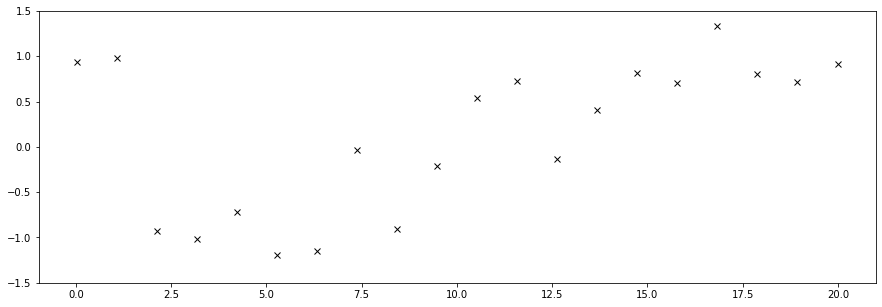

In [7]:
plt.subplots(1, 1, figsize=(15, 5))
plt.plot(OBSERVATION_DATA[0], OBSERVATION_DATA[1], "kx")
plt.ylim([-1.5, 1.5])
plt.show()

## Load VGP model details

In [8]:
vgp_elbo = np.load(os.path.join(main_dir, model_dir, "vgp_elbo.npz"))["elbo"]
print(f"VGP ELBO: {vgp_elbo[-1]}")

VGP ELBO: -24.21742569476118


In [9]:
vgp_posterior_m = np.load(os.path.join(main_dir, model_dir, "vgp_inference.npz"))["m"]
vgp_posterior_S = np.load(os.path.join(main_dir, model_dir, "vgp_inference.npz"))["S"]

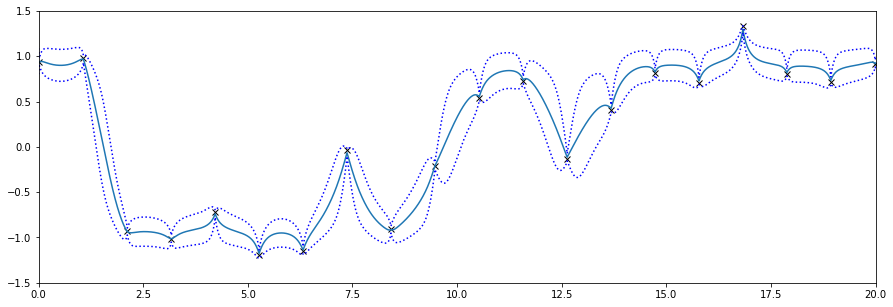

In [10]:
plt.subplots(1, 1, figsize=(15, 5))
plt.plot(OBSERVATION_DATA[0], OBSERVATION_DATA[1], "kx")

plt.plot(TIME_GRID, vgp_posterior_m)
plt.plot(TIME_GRID, (vgp_posterior_m.reshape(-1) - 2 * vgp_posterior_S.reshape(-1)).reshape(-1, ), 
         linestyle="dotted", color="blue")
plt.plot(TIME_GRID, (vgp_posterior_m.reshape(-1) + 2 * vgp_posterior_S.reshape(-1)).reshape(-1, ), 
         linestyle="dotted", color="blue")

plt.ylim([-1.5, 1.5])
plt.xlim([T0, T1])
plt.show()

## t-VGP

In [11]:
true_q = Q * tf.ones((1, 1), dtype=DTYPE)

PRIOR_tVGP_SDE = PriorDoubleWellSDE(q=true_q, initial_a_val=3.0, initial_c_val=1.0)

likelihood = Gaussian(NOISE_VAR)

t_vgp_trainer = tVGPTrainer(observation_data=OBSERVATION_DATA, likelihood=likelihood, time_grid=TIME_GRID,
                            prior_sde=PRIOR_tVGP_SDE, data_sites_lr=1.0,
                            all_sites_lr=0.1, update_all_sites=False)

2022-08-24 11:22:56.360193: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## Update Data-sites and check the values

In [12]:
t_vgp_trainer.tvgp_model.update_sites()

False

In [13]:
t_vgp_model_all_sites = t_vgp_trainer.tvgp_model

data_sites_nat1 = t_vgp_model_all_sites.data_sites.nat1
data_sites_nat2 = t_vgp_model_all_sites.data_sites.nat2
noise_var = likelihood.variance
np.testing.assert_array_almost_equal(data_sites_nat1.numpy(), OBSERVATION_DATA[1] / noise_var)
np.testing.assert_array_almost_equal(tf.reduce_sum(data_sites_nat2),
                                     data_sites_nat2.shape[0] * (-1 / (2 * noise_var)))

In [14]:
print(f"t-VGP ELBO : {t_vgp_trainer.tvgp_model.classic_elbo().numpy().item()}")

t-VGP ELBO : -147.05569143998488


## Linearize the prior and compute posterior till convergence 

In [26]:
lin_converged = False 
min_itr = 5
i = 0

while not lin_converged:
    lin_before_elbo = t_vgp_trainer.tvgp_model.classic_elbo().numpy().item()
    print(f"t-VGP: ELBO before linearization {lin_before_elbo}!!!")
    
    # Compute Posterior
    t_vgp_trainer.tvgp_model.fx_mus, t_vgp_trainer.tvgp_model.fx_covs = t_vgp_trainer.tvgp_model.dist_q.marginals
    
    # Re-linearize
    t_vgp_trainer.tvgp_model.linearization_pnts = (tf.identity(t_vgp_trainer.tvgp_model.fx_mus[:, :-1, :]),
                                          tf.identity(t_vgp_trainer.tvgp_model.fx_covs[:, :-1, :, :]))
    t_vgp_trainer.tvgp_model._linearize_prior()

    lin_after_elbo = t_vgp_trainer.tvgp_model.classic_elbo().numpy().item()
    print(f"t-VGP: ELBO after linearization {lin_after_elbo}!!!")

    if lin_before_elbo > lin_after_elbo:
        print("ELBO decreasing!!!")
        if i > min_itr:
            break

    diff = tf.math.abs(lin_before_elbo - lin_after_elbo)
    print(f"ELBO diff : {diff} \n\n")
    
    if diff < 1e-4:
        lin_converged = True
    
    i = i + 1

t-VGP: ELBO before linearization -23.69961894705249!!!
t-VGP: ELBO after linearization -23.748967336880284!!!
ELBO decreasing!!!
ELBO diff : 0.049348391592502594 


t-VGP: ELBO before linearization -23.748967336880284!!!
t-VGP: ELBO after linearization -23.67395082300726!!!
ELBO diff : 0.07501651346683502 


t-VGP: ELBO before linearization -23.67395082300726!!!
t-VGP: ELBO after linearization -23.690465991628876!!!
ELBO decreasing!!!
ELBO diff : 0.01651516929268837 


t-VGP: ELBO before linearization -23.690465991628876!!!
t-VGP: ELBO after linearization -23.686475584123592!!!
ELBO diff : 0.003990407567471266 


t-VGP: ELBO before linearization -23.686475584123592!!!
t-VGP: ELBO after linearization -23.687916909263667!!!
ELBO decreasing!!!
ELBO diff : 0.0014413251774385571 


t-VGP: ELBO before linearization -23.687916909263667!!!
t-VGP: ELBO after linearization -23.687501068726945!!!
ELBO diff : 0.0004158405354246497 


t-VGP: ELBO before linearization -23.687501068726945!!!
t-VGP: E

## Now update all sites

In [27]:
t_vgp_trainer.tvgp_model.all_sites_lr = 0.1
t_vgp_trainer.tvgp_model.update_all_sites = True

all_sites_converged = False
while not all_sites_converged:
    before_elbo = t_vgp_trainer.tvgp_model.classic_elbo().numpy().item()
    print(f"t-VGP: ELBO before {before_elbo}!!!")
    
    t_vgp_trainer.tvgp_model.update_sites(update_all_sites=True)
    
    after_elbo = t_vgp_trainer.tvgp_model.classic_elbo().numpy().item()
    print(f"t-VGP: ELBO after {after_elbo}!!!")
    
    if before_elbo > after_elbo:
        print("ELBO decreasing!!!")
        break

    diff = tf.math.abs(before_elbo - after_elbo)
    print(f"ELBO diff : {diff} \n\n")
    
    if diff < 1e-4:
        all_sites_converged = True

t-VGP: ELBO before -23.68777153573947!!!
t-VGP: ELBO after -23.776432049775806!!!
ELBO decreasing!!!


In [23]:
t_vgp_trainer.tvgp_model.sites_nat1

<tf.Tensor: shape=(4001, 1), dtype=float64, numpy=
array([[0.02004282],
       [0.01636155],
       [0.01281375],
       ...,
       [0.00529585],
       [0.00797903],
       [0.        ]])>

In [28]:
tvgp_posterior_m, tvgp_posterior_S_std = predict_ssm(t_vgp_trainer.tvgp_model, np.sqrt(NOISE_VAR))

tvgp_posterior_S = tf.square(tvgp_posterior_S_std).numpy()

## Plotting Posterior

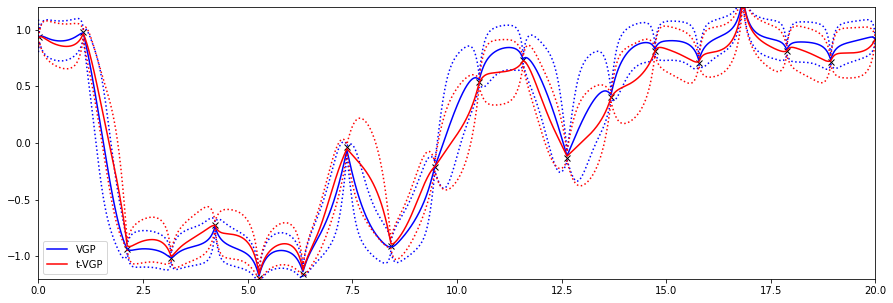

In [29]:
plt.subplots(1, 1, figsize=(15, 5))
plt.plot(OBSERVATION_DATA[0], OBSERVATION_DATA[1], "kx")

plt.plot(TIME_GRID, vgp_posterior_m, color="blue", label="VGP")
plt.plot(TIME_GRID, (vgp_posterior_m.reshape(-1) - 2 * vgp_posterior_S.reshape(-1)).reshape(-1, ), 
         linestyle="dotted", color="blue")
plt.plot(TIME_GRID, (vgp_posterior_m.reshape(-1) + 2 * vgp_posterior_S.reshape(-1)).reshape(-1, ), 
         linestyle="dotted", color="blue")

plt.plot(TIME_GRID, tvgp_posterior_m, color="red", label="t-VGP")
plt.plot(TIME_GRID, (tvgp_posterior_m.reshape(-1) - 2 * tvgp_posterior_S.reshape(-1)).reshape(-1, ), 
         linestyle="dotted", color="red")
plt.plot(TIME_GRID, (tvgp_posterior_m.reshape(-1) + 2 * tvgp_posterior_S.reshape(-1)).reshape(-1, ), 
         linestyle="dotted", color="red")

plt.legend()
plt.ylim([-1.2, 1.2])
plt.xlim([T0, T1])
plt.show()